In [106]:
for (fnm in list.files("rwwa_local", full.names = T)) source(fnm)
suppressMessages(library(extRemes))

# method to extract parameter estimates from Climate Explorer output
cx_par_ests <- function(parstring) {
    cols <- gsub("\\.\\.\\.", "",unlist(strsplit(paste0(unlist(strsplit(cx[grepl(parstring, cx)], "(<.+?>)")), collapse = ""), " +")))
    setNames(as.numeric(cols[length(cols) - (2:0)]), c("est", "lower", "upper"))
}

# How should independent shift+scale be modelled?

- linear scale parameter
- exponential scale parameter
- test against extRemes


- case study: SPI-OND from LA fire study
- synthetic data?
- compare to ClimExp results

# Compare different modelling approaches

In [177]:
fnm <- "ts/debilt_tn1n.txt"; title <- "De Bilt TN1n"; varnm <- "tn1n"; covnm <- "gmst"; fig_nm <- paste0("de-bilt_",varnm,"_", covnm); lower <- T

In [163]:
ts <- read.table(fnm, header = F, col.names = c("year", "tn1n"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))

df <- merge(gmst, ts)

In [183]:
# extract parameters from Climate Explorer output
cx <- readLines(paste0("cx/cx_",fig_nm,"_shiftscale.txt"))
cx_ss_res <- sapply(list("mu0" = "mu;':</td><td>  -1.01", "sigma0" = "sigma;':</td><td>  -1.01", "alpha" = "alpha", "beta" = "beta", "xi" = "xi"), cx_par_ests)

# extract parameters from Climate Explorer output
cx <- readLines(paste0("cx/cx_",fig_nm,"_shift.txt"))
cx_s_res <- sapply(list("mu0" = "mu;':</td><td>  -1.01", "sigma0" = "sigma;':</td><td>  -1.01", "alpha" = "alpha", "xi" = "xi"), cx_par_ests)
cx_s_res <- cbind(cx_s_res, "beta" = NA)[,c("mu0", "sigma0", "alpha", "beta", "xi")]

In [178]:
# internal functions with different types of shift+scale fitting
mdl_shift <- fit_ns("gev", type = "shift", data = df, varnm = varnm, covnm = covnm, lower = lower)
mdl_shiftscale_linear <- fit_ns("gev", type = "shiftscale_linear", data = df, varnm = varnm, covnm = covnm, lower = lower)
mdl_shiftscale_exp <- fit_ns("gev", type = "shiftscale_exp", data = df, varnm = varnm, covnm = covnm, lower = lower)

In [179]:
# use extRemes methods to confirm
fevd_nophi <- fevd(-df[,varnm], data = df, location.fun = ~gmst, scale.fun = ~gmst)
fevd_phi <- fevd(-df[,varnm], data = df, location.fun = ~gmst, scale.fun = ~gmst, use.phi = T)

In [186]:
res <- rbind("shift_linear" = c(mdl_shift$par, "beta" = NA)[c(1,2,3,5,4)],
              "ClimExp shift linear" = cx_s_res["est",],
              "shiftscale_linear" = mdl_shiftscale_linear$par,
              "fevd_nophi" = strip(fevd_nophi)[c("mu0", "sigma0", "mu1", "sigma1", "shape")],
              "ClimExp shiftscale linear" = cx_ss_res["est",],
              "shiftscale_exp" = mdl_shiftscale_exp$par,
              "fevd_phi" = strip(fevd_phi)[c("mu0", "phi0", "mu1", "phi1", "shape")]
              )
res
write.csv(res, paste0("res/pars_",fig_nm,".csv"))

,mu0,sigma0,alpha_gmst,beta,shape
shift_linear,-8.600158,2.991056,2.768694,NA,-0.05944503
ClimExp shift linear,-8.601000,-2.990000,2.772000,NA,-0.06000000
shiftscale_linear,-8.655724,3.216932,3.002408,-0.7802431,-0.04250751
fevd_nophi,8.655765,3.217047,-3.002446,-0.7805228,-0.04250128
ClimExp shiftscale linear,-8.654000,-3.218000,3.001000,0.7790000,-0.04200000
shiftscale_exp,-8.648225,1.162441,2.976816,-0.2447317,-0.04327843
fevd_phi,8.648215,1.162456,-2.976781,-0.2448049,-0.04327560


In [191]:
prep_window(w = 6)

png(paste0("fig/fitted-model_",fig_nm,".png"), height = 300, width = 300*3); {
    prep_window(c(1,3))
    
    x <- unname(unlist(mdl_shiftscale_exp$cov))
    o <- order(x)

    plot(x[o], mdl_shiftscale_exp$x[o], main = title)
    lines(x[o], ns_pars(mdl_shiftscale_linear)$loc[o], lwd = 3, col = "blue")
    lines(x[o], ns_pars(mdl_shiftscale_exp)$loc[o], lwd = 3, col = "red3", lty = 2)
#     lines(x[o], findpars(fevd_nophi)$location[o], lwd = 3, col = "forestgreen", lty = 3)
#     lines(x[o], findpars(fevd_phi)$location[o], lwd = 3, col = "gold", lty = 4)

    rp <- 50
    lines(x[o], eff_return_level(mdl_shiftscale_exp, rp)[o], lwd = 1, col = "blue")
    lines(x[o], eff_return_level(mdl_shiftscale_linear, rp)[o], lwd = 1, col = "red3")
#     lines(x[o], erlevd(fevd_nophi, rp)[o], lwd = 2, col = "forestgreen", lty = 3)
#     lines(x[o], erlevd(fevd_phi, rp)[o], lwd = 2, col = "gold", lty = 3)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ylim = range(c(mdl_shiftscale_exp$x, eff_return_level(mdl_shiftscale_exp, 100)))

    # location parameter is the same
    plot(ns_pars(mdl_shiftscale_exp)$loc, ns_pars(mdl_shiftscale_linear)$loc, pch = 1, main = "Location & return level estimates",
         asp = 1, ylim = ylim, xlim = ylim, xlab = "scale = exp(a + bT)", ylab = "scale = a + bT")
#     points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_phi)$location)
#     points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_nophi)$location, pch = 4, col = "forestgreen")

#     legend("topleft", c("linear scale = a + bT", "FEVD with phi", "FEVD without phi"), pch =c(1,20,4), col = c("gold", "black", "forestgreen"))

    # return levels for moderately unusual events
    rp <- 10
    points(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "darkblue")
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")

    # return levels for extremes
    rp <- 100
    points(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "blue")
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
#     points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")
    abline(0,1, lty = 2)
    
    legend("topleft", c("Location", "RL10", "RL100"), col = c("black", "darkblue", "blue"), pch = 20)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    plot(df$year, return_period(mdl_shiftscale_linear, eff_return_level(mdl_shiftscale_exp, 10)), ylim = c(0,120), xlab = "", ylab = "", main = "RP in linear-scaled fit"); abline(h = 10, lty = 2)
    points(df$year, return_period(mdl_shiftscale_linear, eff_return_level(mdl_shiftscale_exp, 50))); abline(h = 50, lty = 2)
    points(df$year, return_period(mdl_shiftscale_linear, eff_return_level(mdl_shiftscale_exp, 100))); abline(h = 100, lty = 2)
    
}; dev.off()

png 
  2

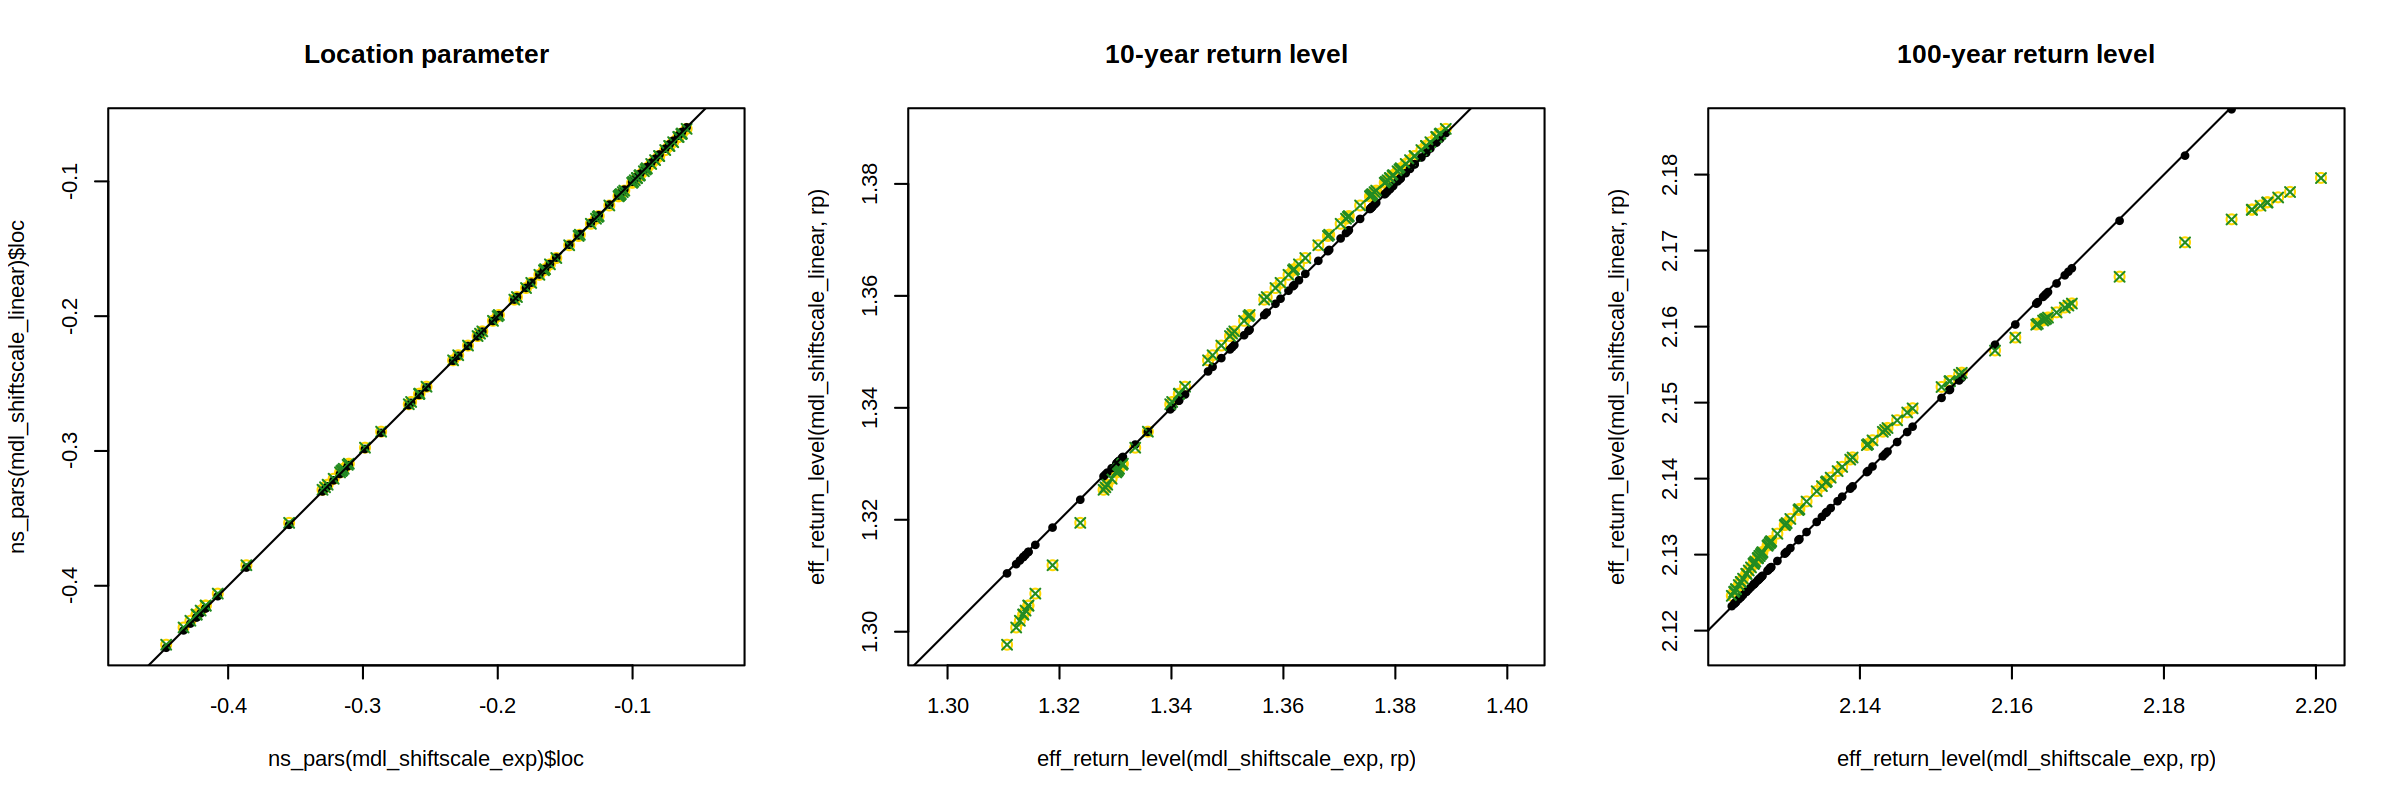

In [153]:
prep_window(c(1,3))

ylim = range(mdl_shiftscale_exp$x)

# location parameter is the same
plot(ns_pars(mdl_shiftscale_exp)$loc, ns_pars(mdl_shiftscale_linear)$loc, pch = 1, col = "gold", main = "Location parameter", asp = 1)
points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_phi)$location)
points(ns_pars(mdl_shiftscale_exp)$loc, findpars(fevd_nophi)$location, pch = 4, col = "forestgreen")
abline(0,1)

# return levels for moderately unusual events
rp <- 10
plot(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "gold", main = paste0(rp,"-year return level"), asp = 1)
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")
abline(0,1)

# return levels for extremes
rp <- 100
plot(eff_return_level(mdl_shiftscale_exp, rp), eff_return_level(mdl_shiftscale_linear, rp), pch = 1, col = "gold", main = paste0(rp,"-year return level"), asp = 1)
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_phi, rp))
points(eff_return_level(mdl_shiftscale_exp, rp), erlevd(fevd_nophi, rp), pch = 4, col = "forestgreen")
abline(0,1)